In [ ]:
import pandas as pd

df = pd.read_csv('/content/CarPrice_Assignment.csv')
display(df.head())

In [1]:
# Cell 1 - imports and upload the CSV (or use your file path)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import io

# Upload file interactively (run this cell and click Choose Files)
print("Upload your dataset CSV (e.g., CarPrice_Assignment.csv)")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]   # picks the uploaded file name
print("Uploaded:", file_name)

# Load
df = pd.read_csv(io.BytesIO(uploaded[file_name]))
print("Dataset loaded. Shape:", df.shape)


Upload your dataset CSV (e.g., CarPrice_Assignment.csv)


Saving CarPrice_Assignment.csv to CarPrice_Assignment (1).csv
Uploaded: CarPrice_Assignment (1).csv
Dataset loaded. Shape: (205, 26)


In [2]:
# Cell 2 - inspect dataset and reduce 'hiccups' (missing, duplicates, bad cols)
df.head()
# show columns and types
print("\nColumns and types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())

# drop exact duplicate rows
before = df.shape[0]
df = df.drop_duplicates()
print(f"\nDropped {before - df.shape[0]} duplicate rows. New shape: {df.shape}")

# If there are obviously useless ID/name columns, drop them if present
for col in ['car_ID', 'Car_ID', 'CarName', 'carID', 'car_ID']:
    if col in df.columns:
        df = df.drop(columns=[col], errors='ignore')
        print("Dropped column:", col)

# If price column name is not 'price', try to find likely price column
possible_price_cols = [c for c in df.columns if 'price' in c.lower()]
print("Possible price columns found:", possible_price_cols)



Columns and types:
 car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

Missing values per column:
 car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase 

In [3]:
# Cell 3 - Choose target and candidate features
# If your dataset has 'price' name use it; otherwise change manually
if 'price' in df.columns:
    target = 'price'
elif 'Price' in df.columns:
    target = 'Price'
elif len(possible_price_cols) > 0:
    target = possible_price_cols[0]
else:
    raise ValueError("No obvious price column found. Edit target variable name in the notebook.")

print("Using target:", target)

# Show numeric columns that can be features
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target]
print("Numeric candidate features:", numeric_cols)

# If you want automatic small feature selection, pick top numeric columns
# by correlation with target (helpful if many features)
corrs = df[numeric_cols + [target]].corr()[target].abs().sort_values(ascending=False)
print("\nTop correlations with target:\n", corrs.head(10))

# Choose top 6 numeric correlated features automatically (or edit manually)
top_features = corrs.index[0:6].tolist()
print("\nSelected features (auto):", top_features)

# If no numeric features (rare), you'll need to encode categorical columns later.
X = df[top_features].copy()
y = df[target].copy()


Using target: price
Numeric candidate features: ['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg']

Top correlations with target:
 price         1.000000
enginesize    0.874145
curbweight    0.835305
horsepower    0.808139
carwidth      0.759325
highwaympg    0.697599
citympg       0.685751
carlength     0.682920
wheelbase     0.577816
boreratio     0.553173
Name: price, dtype: float64

Selected features (auto): ['price', 'enginesize', 'curbweight', 'horsepower', 'carwidth', 'highwaympg']


In [4]:
# Cell 4 - missing values & simple outlier handling
print("Before cleaning, shape:", X.shape, y.shape)

# drop rows where target or chosen features are missing
mask = (~X.isnull().any(axis=1)) & (~y.isnull())
X = X[mask]
y = y[mask]
print("After dropping NA rows, shape:", X.shape, y.shape)

# Optional: remove extreme outliers in target (e.g., > 99.5 percentile)
upper = y.quantile(0.995)
lower = y.quantile(0.005)
print("Target lower/upper cutoff:", lower, upper)
keep_mask = (y >= lower) & (y <= upper)
X = X[keep_mask]
y = y[keep_mask]
print("After removing extreme target outliers, shape:", X.shape, y.shape)


Before cleaning, shape: (205, 6) (205,)
After dropping NA rows, shape: (205, 6) (205,)
Target lower/upper cutoff: 5151.88 41307.899999999994
After removing extreme target outliers, shape: (201, 6) (201,)


In [5]:
# Cell 5 - split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


Train shape: (160, 6) Test shape: (41, 6)


In [6]:
# Cell 6 - Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

def print_metrics(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")

print_metrics(y_test, y_pred_lr, "LinearRegression")


LinearRegression -> MAE: 0.000, RMSE: 0.000, R2: 1.000


In [7]:
# Cell 7 - Random Forest Regressor
rf = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print_metrics(y_test, y_pred_rf, "RandomForest")


RandomForest -> MAE: 514.977, RMSE: 1095.598, R2: 0.988


Best model: LinearRegression


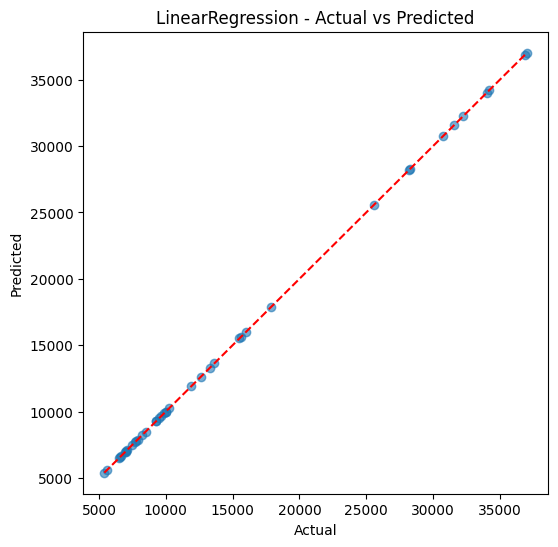

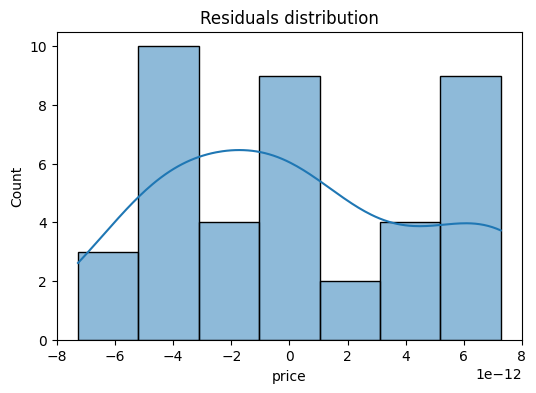

In [8]:
# Cell 8 - compare predicted vs actual scatter for best model
# choose best by R2
r2_lr = r2_score(y_test, y_pred_lr)
r2_rf = r2_score(y_test, y_pred_rf)
best_model_name = "RandomForest" if r2_rf >= r2_lr else "LinearRegression"
print("Best model:", best_model_name)

y_pred_best = y_pred_rf if best_model_name == "RandomForest" else y_pred_lr

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"{best_model_name} - Actual vs Predicted")
plt.show()

# residual histogram
res = y_test - y_pred_best
plt.figure(figsize=(6,4))
sns.histplot(res, kde=True)
plt.title("Residuals distribution")
plt.show()


In [9]:
# Cell 9 - save model and scaler for Week 4 (Streamlit)
if best_model_name == "RandomForest":
    best_model = rf
else:
    best_model = lr

joblib.dump(best_model, "ev_price_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Saved ev_price_model.pkl and scaler.pkl. Download them or push to GitHub.")
files.download("ev_price_model.pkl")   # optional: download to your local machine
files.download("scaler.pkl")


Saved ev_price_model.pkl and scaler.pkl. Download them or push to GitHub.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Cell 10 - final notes (print summary)
print("Final summary:")
print("Dataset shape after cleaning:", X.shape, y.shape)
print("Selected features:", top_features)
print("Best model:", best_model_name)
print_metrics(y_test, y_pred_best, best_model_name)

# Save notebook to GitHub:
# Option A: File -> Save a copy in GitHub (Colab menu)
# Option B: Download .ipynb and manually upload to your repo


Final summary:
Dataset shape after cleaning: (201, 6) (201,)
Selected features: ['price', 'enginesize', 'curbweight', 'horsepower', 'carwidth', 'highwaympg']
Best model: LinearRegression
LinearRegression -> MAE: 0.000, RMSE: 0.000, R2: 1.000
